# CNN & VGG16 for CIFAR10

This project is done for NTU's IE4483 AI & Data Mining Course.

We explore VGG16 & create our own ResNet imitation model.

This notebook is contains all code required to run the pipeline.

> The Cat Dog Dataset has been migrated to another drive folder to preserve it just in case the link is down.

## Dataset Preparation

**This notebook will automatically download the datasets required.**

We firstly download our Cat Dog Dataset from Google Drive, then unzip it.

CIFAR10 will be automatically downloaded later through PyTorch's API

In [1]:
!pip install gdown
!gdown 1pAUMqb0wKtdc5_Jep-YKCPdf8TWaIJXN

  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14820 sha256=10cb0f050ec2a8f7198d708afa331a3115f781739361014195174e582b334746
  Stored in directory: /home/runner/.cache/pip/wheels/26/96/6b/c1affd461eb8b531b3004666b67855017c5819b59187620f8d
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1pAUMqb0wKtdc5_Jep-YKCPdf8TWaIJXN
To: /home/runner/work/IE4483/IE4483/datasets.zip
100%|██████████████████████████████████████| 1.10G/1.10G [00:17<00:00, 64.2MB/s]


In [2]:
import os
import zipfile

with zipfile.ZipFile("datasets.zip", 'r') as zip_ref:
    zip_ref.extractall("./")
os.remove("datasets.zip")

Following, we'll `pip install` dependencies

Note that the installation may vary for different CUDA versions. I use `cu117` as I'm on CUDA 11.8

In [3]:
!pip install torch torchvision torchaudio numpy pandas scikit-learn matplotlib pytorch-lightning --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


We define the root directory to make sure that our downloads are in the right place

In [4]:
from pathlib import Path
ROOT_DIR = Path("./")

## Datasets

We'll wrap the datasets in OOP classes to make it easy to use later on.

Here, we implement:
- `DatasetWrapper` which is the child of both following datasets
- `CatDogDataset`
- `CIFAR10Dataset`

In [5]:
from abc import abstractmethod, ABC
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder


@dataclass
class DatasetWrapper(ABC):
    classes: Tuple[str]
    train_path: Path
    val_path: Path
    test_path: Path = None

    augment: bool = False

    img_size: int = 128
    batch_size: int = 64
    train_workers: int = 4
    val_workers: int = 2

    class SquarePad:
        def __call__(self, image):
            _, h, w = image.shape
            max_wh = max(w, h)
            hp = int((max_wh - w) / 2)
            vp = int((max_wh - h) / 2)
            padding = [hp, vp, hp, vp]
            return transforms.Pad(padding)(image)

    @property
    @abstractmethod
    def train_transform(self):
        ...

    @property
    @abstractmethod
    def test_transform(self):
        ...

    @property
    def train_augments(self):
        return [
            transforms.RandomRotation(15),
            transforms.RandomPerspective(0.2),
            transforms.GaussianBlur(5, (0.1, 0.5)),
            transforms.ColorJitter(0.2, 0.2, 0.5, 0.1),
            transforms.RandomHorizontalFlip(),
        ]

    @property
    def train_ds(self):
        return ImageFolder(self.train_path.as_posix(), self.train_transform)

    @property
    def val_ds(self):
        return ImageFolder(self.val_path.as_posix(), self.test_transform)

    @property
    def test_ds(self):
        return ImageFolder(self.test_path.as_posix(), self.test_transform)

    @property
    def train_dl(self) -> DataLoader:
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.train_workers)

    @property
    def val_dl(self) -> DataLoader:
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.val_workers)

    @property
    def val_shuffle_dl(self) -> DataLoader:
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.val_workers)

    @property
    def test_dl(self) -> DataLoader:
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.val_workers)


In [6]:
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple
from torchvision.transforms import InterpolationMode


@dataclass
class CatDogDataset(DatasetWrapper):
    train_path: Path = ROOT_DIR / Path("datasets") / "train"
    val_path: Path = ROOT_DIR / Path("datasets") / "val"
    classes: Tuple[str] = ('cat', 'dog')

    @property
    def train_transform(self):
        if self.augment:
            return transforms.Compose([
                transforms.ToTensor(),
                self.SquarePad(),
                transforms.Resize((self.img_size, self.img_size), InterpolationMode.NEAREST),
                *self.train_augments,
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            return transforms.Compose([
                transforms.ToTensor(),
                self.SquarePad(),
                transforms.Resize((self.img_size, self.img_size), InterpolationMode.NEAREST),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    @property
    def test_transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            self.SquarePad(),
            transforms.Resize((self.img_size, self.img_size), InterpolationMode.NEAREST),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    @property
    def test_ds(self):
        return self.val_ds

In [7]:
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple

from torch.utils.data import random_split
from torchvision.datasets import CIFAR10

@dataclass
class CIFAR10Dataset(DatasetWrapper):
    train_path: Path = ROOT_DIR / Path("cifar10_dataset") / "train"
    val_path: Path = ROOT_DIR / Path("cifar10_dataset") / "val"
    dataset_path: Path = ROOT_DIR / "cifar10_dataset"
    classes: Tuple[str] = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def __post_init__(self):
        """ Load CIFAR 10 """
        train_ds = CIFAR10(
            root=self.dataset_path.as_posix(), train=True, download=True,
            transform=self.train_transform
        )

        train_size = int(len(train_ds) * 0.7)
        val_size = int(len(train_ds) - train_size)
        self.train_ds_, self.val_ds_ = random_split(train_ds, [train_size, val_size],
                                                    generator=torch.Generator().manual_seed(373))
        self.test_ds_ = CIFAR10(
            root=self.dataset_path.as_posix(), train=False, download=True,
            transform=self.test_transform
        )

    @property
    def train_transform(self):
        if self.augment:
            return transforms.Compose([
                transforms.ToTensor(),
                *self.train_augments,
                transforms.Resize((self.img_size, self.img_size), InterpolationMode.NEAREST),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            return transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((self.img_size, self.img_size), InterpolationMode.NEAREST),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    @property
    def test_transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    @property
    def train_ds(self):
        return self.train_ds_

    @property
    def val_ds(self):
        return self.val_ds_

    @property
    def test_ds(self):
        return self.test_ds_


## Models

Similarly, we'll implement our models with Python OOP.

We implement:
- `LitWrapper` which implements common `pytorch-lightning` procedures
- `ResNet13`, our proposed model
- `VGG16` that wraps PyTorch's `vgg16`

In [8]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau


class LitWrapper(pl.LightningModule):
    def __init__(self, model, seed: int = 373):
        """ This wraps respective PyTorch models into a LightningModule, which creates commonly used functions.

        Args:
            model: The PyTorch model class INSTANCE
            seed: Seed to train the model in
        """
        super().__init__()
        seed_everything(seed)
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y_true)
        self.log("train_acc", self.acc(y_pred, y_true))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        self.log("val_acc", self.acc(y_pred, y_true))

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        return self(x)

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=0.0005, weight_decay=0.0001)

        return {
            "optimizer": optim,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(optim, mode='max', factor=0.1, patience=2, verbose=True),
                "monitor": "val_acc",
            },
        }

    @staticmethod
    def acc(y_pred: torch.Tensor, y_true: torch.Tensor):
        y_pred_ix = torch.argmax(y_pred, dim=1)
        return torch.sum(y_pred_ix == y_true) / y_true.shape[0]


In [9]:
import torch.nn as nn


class CNNBlock(nn.Module):
    def __init__(self, c_in: int, c_out: int, kernel: int = 3, ave_pool: bool = True):
        """ Implements the common block for our custom CNN

        Args:
            c_in: Number of Channels input
            c_out: Number of Channels output
            kernel: Size of kernel (the length of each side). Must be odd
            ave_pool: Whether to average pool after the block
        """
        super(CNNBlock, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel, 1, int((kernel - 1) // 2)),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
        )
        if ave_pool:
            self.net.append(nn.AvgPool2d(2, 2))

    def forward(self, x):
        return self.net(x)


class ResNet13(nn.Module):
    def __init__(self, out_dims: int = 2):
        """ Implements our custom CNN Model, inspired by deep CNNs

        Notes:
            We noted that deep CNNs usually:
            - Increase Channels in further layers
            - Use small kernel sizes (like 3)
            - Modern Deep CNNs use padding to avoid having to correct image dimension reduction after convolution
            - Use Average/Max Pool to shrink image sizes

        Args:
            out_dims: How many categories to output. E.g. Cat & Dog will use 2.
        """
        super(ResNet13, self).__init__()

        self.net = nn.Sequential(
            CNNBlock(3, 16, 7, ave_pool=False),
            CNNBlock(16, 16, 5),
            CNNBlock(16, 32),
            CNNBlock(32, 32, ave_pool=False),
            CNNBlock(32, 64),
            CNNBlock(64, 64, ave_pool=False),
            CNNBlock(64, 128),
            CNNBlock(128, 128, ave_pool=False),
            CNNBlock(128, 128),
            CNNBlock(128, 128, ave_pool=False),
            CNNBlock(128, 128),
            CNNBlock(128, 128, ave_pool=False),
            CNNBlock(128, 128),
            nn.Flatten(),
            nn.Linear(128, out_dims),
            nn.Dropout(0.1),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.net(x)

In [10]:
import torch.nn as nn
from torchvision.models import VGG16_Weights
from torchvision.models import vgg16


class VGG16(nn.Module):
    def __init__(self, out_dims: int = 2):
        """ Implements the pretrained VGG16 trained on the ImageNet 1K Dataset.

        Notes:
            This freezes all prior layers that extracts important features from the images.
            This will also add a final Linear layer to it

        Args:
            out_dims: How many categories to output. E.g. Cat & Dog will use 2.
        """
        super(VGG16, self).__init__()
        self.net = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

        for p in self.net.parameters():
            p.requires_grad = False

        self.net.classifier = nn.Sequential(
            *[_ for _ in self.net.classifier.children()][:-1],
            nn.Linear(4096, out_dims),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


## Plotter

We'll also implement a plotting function here to show prediction examples of our model

In [11]:
from typing import Tuple

import torch
from pytorch_lightning import seed_everything
from sklearn.preprocessing import minmax_scale
from torch.utils.data import DataLoader
import pytorch_lightning as pl



def plot_predictions(
        trainer: pl.Trainer,
        model: LitWrapper,
        true_dl: DataLoader,
        class_mapping: Tuple[str],
        seed: int = 373,
        rows_cols: Tuple[int, int] = (8, 8),
        figsize: Tuple[int, int] = (10, 12)
):
    """ Plots the predictions of a batch

    Args:
        trainer: PyTorch Lightning Trainer
        model: PyTorch Lightning Module Instance
        true_dl: DataLoader (can be shuffled)
        class_mapping: Tuple of classes mapped to indices
        seed: Seed of Image Shuffle
        rows_cols: Number of rows and columns
        figsize: Size of figure

    """
    fig, axs = plt.subplots(*rows_cols, figsize=figsize)
    seed_everything(seed)
    preds = trainer.predict(model, true_dl)
    seed_everything(seed)
    for pred_b, true_b in zip(preds, true_dl):
        for pred, true, true_ix, ax in zip(pred_b, true_b[0], true_b[1], axs.flatten()):
            true = true.swapaxes(0, -1).swapaxes(0, 1)
            pred_ix = torch.argmax(pred)
            ax.axis('off')
            ax.imshow(minmax_scale(true.reshape(-1, 3)).reshape(true.shape))
            ax.set_title(f"{class_mapping[pred_ix.item()]} / {class_mapping[true_ix.item()]}")
        break
    _ = plt.suptitle("Predict / Actual")
    _ = plt.tight_layout()
    _ = plt.subplots_adjust(top=0.95)


## Training Function

Finally, we implement a training function that we can call for our various experiments

In [12]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping

def train(ds, model, log_dir, use_gpu:bool = True, fast_dev_run: bool = True,
          epochs: int = 10):
  early_stop_callback = EarlyStopping(monitor="val_acc", min_delta=0.00,
                                      patience=4, verbose=False, mode="max")
  model = LitWrapper(model)
  trainer = pl.Trainer(
      deterministic=True,
      max_epochs=epochs,
      accelerator='gpu' if use_gpu else 'cpu',
      callbacks=[early_stop_callback],
      default_root_dir=log_dir,        
      fast_dev_run=fast_dev_run,
  )

  trainer.fit(model,train_dataloaders=ds.train_dl,
              val_dataloaders=ds.val_dl)
  return trainer, model

# Training

We run the training loop here

If you're viewing from Google Colab, you can see a form on the right. These are defined by the `#@param` comments.
Otherwise, you can adjust the parameters manually.

For example:
- `Dataset` can take on both datasets: `CIFAR10Dataset`, `CatDogDataset`.

**Parameters:**
- `Dataset`: Can be either `CIFAR10Dataset` or `CatDogDataset`
- `Model`: Can be either `VGG16` or `ResNet13`
- `batch_size`: Defines the Batch Size, 128 worked fine for me locally and on Colab
- `workers`: Number of workers. You may want to set this higher if not using Colab
- `epochs`: Epochs
- `use_gpu`: Must enable if you're using GPU, otherwise CPU is used
- `augment`: Whether to enable Image Augmentation. This is very costly to run. However, may prove to yield better results. For us, we didn't get significantly better ones.
- `fast_dev_run`: If `True`, the loop will terminate after 1 batch of training, validation & prediction. This is to test behavior before engaging in a timely wait.

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/runner/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Global seed set to 373
/opt/hostedtoolcache/Python/3.8.14/x64/lib/python3.8/site-packages/torch/cuda/__init__.py:529: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name  | Type  | Params
--------------------------------
0 | model | VGG16 | 134 M 
--------------------------------
8.2 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.075   Total estimated model params size (MB)
/opt/hostedtoolcache

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.
Global seed set to 373
/opt/hostedtoolcache/Python/3.8.14/x64/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Predicting: 1it [00:00, ?it/s]

Global seed set to 373


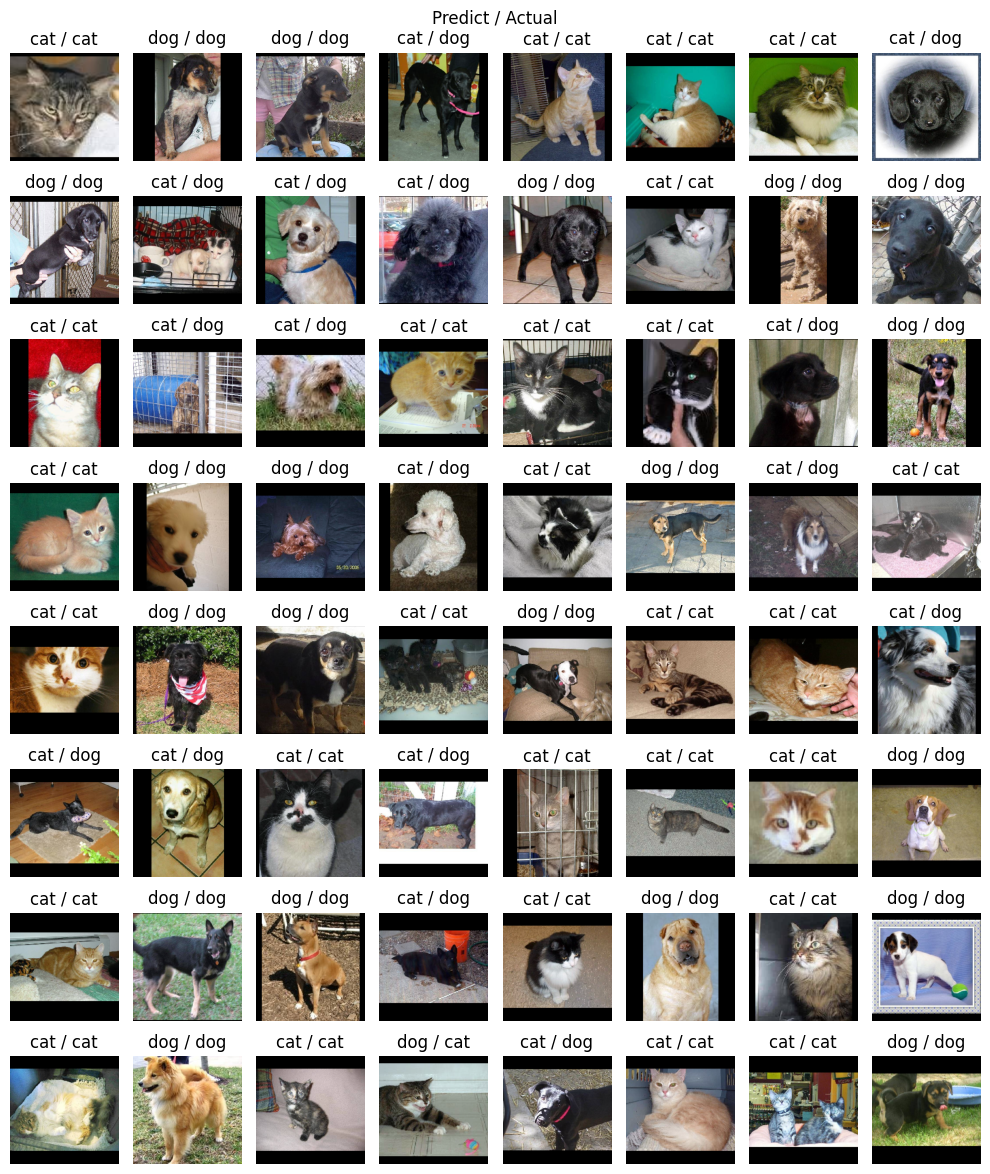

In [13]:
from src.model.resnet13 import ResNet13
from src.model.vgg16 import VGG16
from src.dataset.cifar10_dataset import CIFAR10Dataset
from src.dataset.cat_dog_dataset import CatDogDataset
from src.plot.plot_predictions import plot_predictions

# The Dataset and Model can be swapped with another.
Dataset = CatDogDataset  # CIFAR10Dataset
Model = VGG16  # ResNet13

# Hyper parameters
batch_size = 128
workers = 2
epochs = 20
use_gpu = False
augment = False

# Set to true if we want to quickly test the behavior
fast_dev_run = True

classes = 10 if Dataset == CIFAR10Dataset else 2
img_size = 128 if Model == ResNet13 else 224

ds = Dataset(img_size=img_size,
             batch_size=batch_size,
             train_workers=workers,
             val_workers=workers,
             augment=augment)
model = Model(classes)

# This retrieves the model class name as a string
# So ResNet13 will output ResNet13_CatDogDataset
name = f"{Model.__name__}_{Dataset.__name__}"

# Train the model here
trainer, model = train(
    model=model, ds=ds,
    log_dir=f"{name}_logs/",
    use_gpu=use_gpu,
    epochs=epochs,
    fast_dev_run=fast_dev_run
)

# Then plot what it predicted
plot_predictions(
    trainer, model, class_mapping=ds.classes,
    true_dl=ds.val_shuffle_dl
)

plt.savefig(f"{name}_pred.png")

## Tensorboard

You may view the results through tensorboard.

Make sure to specify the correct pathing of the logs in the 2nd line.

In [14]:
%reload_ext tensorboard
%tensorboard --logdir VGG16_CIFAR10Dataset_logs/lightning_logs/

# Prediction

We extract all the predictions from our `test` folder.

Note that the output here isn't exactly the expected `submission.csv` from the IE4483 course.

This only works with `CatDogDataset`.

In [15]:
import torch
from pathlib import Path
from PIL import Image

from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

import pandas as pd
run_predict = False

if run_predict:
    ars = []
    paths = []
    y = []

    ds = Dataset(img_size=img_size,
                 batch_size=batch_size,
                 train_workers=workers,
                 val_workers=workers,
                 augment=augment)

    ts = ds.test_transform
    for e, p in enumerate (tqdm(ROOT_DIR / Path("datasets/test/").glob("*.jpg"))):
      ar = ts(Image.open(p.as_posix()))
      ars.append(ar)
      y.append(torch.ones([1],dtype=torch.uint8))
      paths.append(p.as_posix())

    ars = torch.stack(ars)
    y =  torch.stack(y)

    tds = TensorDataset(ars, y)
    dl = DataLoader(tds)

    preds = torch.stack(trainer.predict(model, dl))
    pred_confs = torch.squeeze(torch.max(preds, dim=2)[0])
    preds = torch.squeeze(preds.argmax(dim=2))
    preds = [ds.classes[i] for i in preds]

    df = pd.DataFrame(dict(path=paths, pred=preds, pred_max_conf=pred_confs))
    df.to_csv(f"{Model.__name__}_test_predictions.csv")